
### Data Collection and Preprocessing
  - Collect historical energy consumption,holidays, pricing, weather, and population data.
  - Preprocess the data, handle missing values, and engineer features.

In [124]:
## Import Libraries 

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import io 
import os

from bs4 import BeautifulSoup


### Data Directories 

In [319]:
## Creating two directories to store the data (one for raw data, and one for processed data)
# Create directories for raw and cleaned data if they don't exist
raw_data_dir = 'raw_data'
cleaned_data_dir = 'cleaned_data'
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(cleaned_data_dir, exist_ok=True)

### Demand Data

In [159]:
## Getting all demand data from IESO website and putting into a data directory

# URL of the webpage containing the links to the CSV files
url = 'http://reports.ieso.ca/public/Demand/'

# Create a directory to store the downloaded files
os.makedirs('demand_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find all anchor tags (<a>) that contain links to CSV files
links = soup.find_all('a', href=True)

# Extract the filenames from the href attributes of the anchor tags
csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

# Download each CSV file and save it in the "data" directory
for filename in csv_files:
    file_url = url + filename
    response = requests.get(file_url)
    with open(os.path.join('demand_data', filename), 'wb') as f:
        f.write(response.content)
        print(f"Downloaded {filename}")

Downloaded PUB_Demand.csv
Downloaded PUB_Demand_2002.csv
Downloaded PUB_Demand_2002_v1.csv
Downloaded PUB_Demand_2003.csv
Downloaded PUB_Demand_2003_v1.csv
Downloaded PUB_Demand_2004.csv
Downloaded PUB_Demand_2004_v1.csv
Downloaded PUB_Demand_2005.csv
Downloaded PUB_Demand_2005_v1.csv
Downloaded PUB_Demand_2006.csv
Downloaded PUB_Demand_2006_v1.csv
Downloaded PUB_Demand_2007.csv
Downloaded PUB_Demand_2007_v1.csv
Downloaded PUB_Demand_2008.csv
Downloaded PUB_Demand_2008_v1.csv
Downloaded PUB_Demand_2009.csv
Downloaded PUB_Demand_2009_v1.csv
Downloaded PUB_Demand_2010.csv
Downloaded PUB_Demand_2010_v1.csv
Downloaded PUB_Demand_2011.csv
Downloaded PUB_Demand_2011_v1.csv
Downloaded PUB_Demand_2012.csv
Downloaded PUB_Demand_2012_v1.csv
Downloaded PUB_Demand_2013.csv
Downloaded PUB_Demand_2013_v1.csv
Downloaded PUB_Demand_2014.csv
Downloaded PUB_Demand_2014_v1.csv
Downloaded PUB_Demand_2015.csv
Downloaded PUB_Demand_2015_v1.csv
Downloaded PUB_Demand_2016.csv
Downloaded PUB_Demand_2016_v1.csv

In [160]:
## Define a function to read the demand data from a CSV file and return a DataFrame in proper format
def read_csv(filename):
    # Read the CSV file into a DataFrame, skipping the first three rows
    df = pd.read_csv(filename, skiprows=[0, 1])
    # Set column names from the fourth row
    df.columns = df.iloc[0]
    # Drop the fourth row
    df = df.drop(index=0).reset_index(drop=True)
    return df

In [161]:
#Defining a function to combine all the CSV files into a single DataFrame

def combine_csvs(directory):
    """Combine all CSV files in a directory into a single DataFrame."""

# List to store DataFrames for each CSV file
    dfs = []

    # Iterate over each CSV file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            # Clean and read the CSV file into a DataFrame
            df = read_csv(file_path)
            dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)

    # Sort by the 'Date' column
    df = df.sort_values('Date')
    return df


In [162]:
## Define a function that takes a DataFrame and returns a new DataFrame with the 'Date' and 'Hour' columns combined into a single 'DateTime' column
def combine_date_hour(df):
    """Combine 'Date' and 'Hour' columns into a single 'DateTime' column."""
    # Convert 'Hour' to 24-hour format as integer and subtract 1
    df['Hour'] = (df['Hour'].astype(int) - 1) % 24  # Ensure hour values are within 0-23 range
    # Combine 'Date' and 'Hour' strings
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')
    # Drop 'Date' and 'Hour' columns
    df.drop(columns=['Date', 'Hour'], inplace=True)
    # # Sort DataFrame by the 'DateTime' column
    df.sort_values(by='DateTime', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

In [164]:
## Get the combined demand data, sort the date, and return the final dataframe 

# Combine all CSV files in the "data" directory into a single DataFrame
df_d = combine_csvs('demand_data')
# Combine the 'Date' and 'Hour' columns into a single 'DateTime' column
df_d  = combine_date_hour(df_d )
## set index to DateTime
df_d .set_index('DateTime', inplace=True)
## Sort the DataFrame by the 'DateTime' column
df_d .sort_values(by='DateTime', inplace=True)
# Remove duplicate rows
df_d = df_d.drop_duplicates()

# Display the first 50 rows of the DataFrame
df_d .head(50)

,Market Demand,Ontario Demand
DateTime,,
2002-05-01 00:00:00,14141,14137
2002-05-01 01:00:00,13876,13872
2002-05-01 02:00:00,13974,13820
2002-05-01 03:00:00,13898,13744
2002-05-01 04:00:00,14378,14224
2002-05-01 05:00:00,15408,15404
2002-05-01 06:00:00,17070,17066
2002-05-01 07:00:00,17644,17640
2002-05-01 08:00:00,17723,17719


### Pricing Data 






In [156]:
import requests
import os

# URL of the directory containing the CSV files
url = 'http://reports.ieso.ca/public/PriceHOEPPredispOR/'

# Create a directory to store the downloaded files
os.makedirs('price_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find all anchor tags (<a>) that contain links to CSV files
links = soup.find_all('a', href=True)

# Extract the filenames from the href attributes of the anchor tags
csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

# Download each CSV file and save it in the "data" directory
for filename in csv_files:
    file_url = url + filename
    response = requests.get(file_url)
    with open(os.path.join('price_data', filename), 'wb') as f:
        f.write(response.content)
        print(f"Downloaded {filename}")



Downloaded PUB_PriceHOEPPredispOR.csv
Downloaded PUB_PriceHOEPPredispOR_2002.csv
Downloaded PUB_PriceHOEPPredispOR_2002_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2003.csv
Downloaded PUB_PriceHOEPPredispOR_2003_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2004.csv
Downloaded PUB_PriceHOEPPredispOR_2004_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2005.csv
Downloaded PUB_PriceHOEPPredispOR_2005_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2006.csv
Downloaded PUB_PriceHOEPPredispOR_2006_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2007.csv
Downloaded PUB_PriceHOEPPredispOR_2007_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2008.csv
Downloaded PUB_PriceHOEPPredispOR_2008_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2009.csv
Downloaded PUB_PriceHOEPPredispOR_2009_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2010.csv
Downloaded PUB_PriceHOEPPredispOR_2010_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2011.csv
Downloaded PUB_PriceHOEPPredispOR_2011_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2012.csv
Downloaded PUB_PriceHOEPPredi

In [157]:
# Combine all CSV files in the "data" directory into a single DataFrame
df = combine_csvs('price_data')
# Combine the 'Date' and 'Hour' columns into a single 'DateTime' column
df = combine_date_hour(df)
## set index to DateTime
df.set_index('DateTime', inplace=True)
## Sort the DataFrame by the 'DateTime' column
df.sort_values(by='DateTime', inplace=True)
# Remove duplicate rows
df = df.drop_duplicates()
# Display the first 50 rows of the DataFrame
df.head(50)

,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
DateTime,,,,,,,
2002-05-01 00:00:00,22.97,14.53,14.53,14.53,NaN,NaN,NaN
2002-05-01 01:00:00,23.27,21.31,21.37,21.37,NaN,NaN,NaN
2002-05-01 02:00:00,24.54,25.45,21.38,21.38,NaN,NaN,NaN
2002-05-01 03:00:00,15.17,24.92,24.92,14.53,NaN,NaN,NaN
2002-05-01 04:00:00,23.59,27.38,27.38,27.4,NaN,NaN,NaN
2002-05-01 05:00:00,28.84,30.34,30.18,30.18,NaN,NaN,NaN
2002-05-01 06:00:00,30.63,30.78,30.78,30.49,NaN,NaN,NaN
2002-05-01 07:00:00,32.23,30.92,30.92,30.92,NaN,NaN,NaN
2002-05-01 08:00:00,30,30.22,30.73,30.73,NaN,NaN,NaN


#### Weather Data (Environment Canada)




In [149]:
## Test out getting 1 month of data 

month = "01" # January
year = "2020" # 2020
stationID = 51459 #Vancouver

base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
api_endpoint = base_url + query_url

print("Click me to download CSV data:")
print(api_endpoint)

Click me to download CSV data:
http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51442&Year=2020&Month=01&timeframe=1


In [ ]:
month = "01" # January
year = "2020" # 2020
stationID = 51442 #Vancouver

base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
api_endpoint = base_url + query_url

print("Click me to download CSV data:")
print(api_endpoint)

https://climate.weather.gc.ca/climate_data/daily_data_e.html?

### Ontario Holidays 



In [165]:
## Add holidays to the demand data frame
## Copy deamnd df 
df3 = df_d.copy()

In [167]:
import holidays 
hols = holidays.Canada(state = 'ON')


In [168]:
## Add holidays to the demand data frame

df3['Holiday'] = pd.Series(df3.index.date).apply(lambda x: x in hols).values

In [169]:
df3.head(50)

,Market Demand,Ontario Demand,Holiday
DateTime,,,
2002-05-01 00:00:00,14141,14137,False
2002-05-01 01:00:00,13876,13872,False
2002-05-01 02:00:00,13974,13820,False
2002-05-01 03:00:00,13898,13744,False
2002-05-01 04:00:00,14378,14224,False
2002-05-01 05:00:00,15408,15404,False
2002-05-01 06:00:00,17070,17066,False
2002-05-01 07:00:00,17644,17640,False
2002-05-01 08:00:00,17723,17719,False


## Population Data 



In [172]:


# URL of the webpage containing the links to the CSV files
url = 'https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/14100287/en'

# Create a directory to store the downloaded files
os.makedirs('population_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find all anchor tags (<a>) that contain links to CSV files
links = soup.find_all('a', href=True)

# Extract the filenames from the href attributes of the anchor tags
csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

# Download each CSV file and save it in the "data" directory
for filename in csv_files:
    file_url = url + filename
    response = requests.get(file_url)
    with open(os.path.join('population_data', filename), 'wb') as f:
        f.write(response.content)
        print(f"Downloaded {filename}")


/var/folders/vr/r8mf2bqs5rq239fpzg2_n3z00000gn/T/ipykernel_3788/640124098.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(response.content, 'html.parser')


In [173]:
import os
import requests
from bs4 import BeautifulSoup

# URL of the webpage containing the links to the CSV files
url = "https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/14100287/en"

# Create a directory to store the downloaded files
os.makedirs('population_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Check the content type of the response
content_type = response.headers.get('content-type')
print("Content-Type:", content_type)

# Parse the HTML content of the webpage if it's HTML
if 'text/html' in content_type:
    # Parse the HTML content of the webpage
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all anchor tags (<a>) that contain links to CSV files
    links = soup.find_all('a', href=True)

    # Extract the filenames from the href attributes of the anchor tags
    csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

    # Download each CSV file and save it in the "population_data" directory
    for filename in csv_files:
        file_url = url + filename
        response = requests.get(file_url)
        with open(os.path.join('population_data', filename), 'wb') as f:
            f.write(response.content)
            print(f"Downloaded {filename}")
else:
    # If the content type is not HTML, handle it accordingly (e.g., save it directly to a file)
    with open('population_data/full_table.csv', 'wb') as f:
        f.write(response.content)
        print("Downloaded full_table.csv")


Content-Type: application/json
Downloaded full_table.csv


In [175]:
import os
import requests

# URL of the webpage containing the links to the CSV files
url = 'https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/14100287/en'

# Create a directory to store the downloaded files
os.makedirs('population_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON content of the response
    json_data = response.json()
    
    # Extract the download link from the JSON data
    download_link = json_data['object']
    
    # Download the CSV file and save it in the "population_data" directory
    filename = 'full_table.csv'
    response = requests.get(download_link)
    if response.status_code == 200:
        with open(os.path.join('population_data', filename), 'wb') as f:
            f.write(response.content)
            print(f"Downloaded {filename}")
    else:
        print("Failed to download the CSV file.")
else:
    print("Failed to retrieve data from the URL.")


Downloaded full_table.csv


In [183]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the website to scrape
url = 'https://www.neilsberg.com/insights/ontario-or-population-by-year/'

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table containing population data
table = soup.find('table')

# Extract table headers
headers = [th.text.strip() for th in table.find_all('th')]

# Extract table rows
data = []
for row in table.find_all('tr')[1:]:
    row_data = [td.text.strip() for td in row.find_all('td')]
    data.append(row_data)

# Create a DataFrame
df = pd.DataFrame(data, columns=headers)

# Save the DataFrame as a CSV file
df.to_csv('ontario_population.csv', index=False)

print("CSV file saved successfully.")


CSV file saved successfully.


In [344]:
# Save the raw GDP data to a CSV file in the raw data directory
raw_pop_file_path = os.path.join(raw_data_dir, 'raw_pop_data.csv')
df_pop.to_csv(raw_pop_file_path)

print(f"Raw GDP data saved to: {raw_pop_file_path}")

Raw GDP data saved to: raw_data/raw_pop_data.csv


In [186]:
## Get the population data from the CSV file
df_pop = pd.read_csv('ontario_population.csv')
df_pop.head(30)

,Year,Population,Year on Year Change,Change in Percent
0,2000,"11,216",-,-
1,2001,"11,283",67,0.6%
2,2002,"11,278",-5,-0.04%
3,2003,"11,229",-49,-0.43%
4,2004,"11,178",-51,-0.45%
5,2005,"11,196",18,0.16%
6,2006,"11,199",3,0.03%
7,2007,"11,236",37,0.33%
8,2008,"11,152",-84,-0.75%
9,2009,"11,123",-29,-0.26%


### GDP Data
Downloaded manually for this iteration from 
https://data.ontario.ca/dataset/ontario-economic-accounts/resource/98f4bed6-2481-4c0b-83e5-009c35bfeb5f

In [290]:
## Read xlsx file 

df_dgp = pd.read_excel('Economic_data/ON_GDP.xlsx')
pd.set_option('display.max_columns', None)
df_dgp.head(100)


,"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",1981 I,1981 II,1981 III,1981 IV,1982 I,1982 II,1982 III,1982 IV,1983 I,1983 II,1983 III,1983 IV,1984 I,1984 II,1984 III,1984 IV,1985 I,1985 II,1985 III,1985 IV,1986 I,1986 II,1986 III,1986 IV,1987 I,1987 II,1987 III,1987 IV,1988 I,1988 II,1988 III,1988 IV,1989 I,1989 II,1989 III,1989 IV,1990 I,1990 II,1990 III,1990 IV,1991 I,1991 II,1991 III,1991 IV,1992 I,1992 II,1992 III,1992 IV,1993 I,1993 II,1993 III,1993 IV,1994 I,1994 II,1994 III,1994 IV,1995 I,1995 II,1995 III,1995 IV,1996 I,1996 II,1996 III,1996 IV,1997 I,1997 II,1997 III,1997 IV,1998 I,1998 II,1998 III,1998 IV,1999 I,1999 II,1999 III,1999 IV,2000 I,2000 II,2000 III,2000 IV,2001 I,2001 II,2001 III,2001 IV,2002 I,2002 II,2002 III,2002 IV,2003 I,2003 II,2003 III,2003 IV,2004 I,2004 II,2004 III,2004 IV,2005 I,2005 II,2005 III,2005 IV,2006 I,2006 II,2006 III,2006 IV,2007 I,2007 II,2007 III,2007 IV,2008 I,2008 II,2008 III,2008 IV,2009 I,2009 II,2009 III,2009 IV,2010 I,2010 II,2010 III,2010 IV,2011 I,2011 II,2011 III,2011 IV,2012 I,2012 II,2012 III,2012 IV,2013 I,2013 II,2013 III,2013 IV,2014 I,2014 II,2014 III,2014 IV,2015 I,2015 II,2015 III,2015 IV,2016 I,2016 II,2016 III,2016 IV,2017 I,2017 II,2017 III,2017 IV,2018 I,2018 II,2018 III,2018 IV,2019 I,2019 II,2019 III,2019 IV,2020 I,2020 II,2020 III,2020 IV,2021 I,2021 II,2021 III,2021 IV,2022 I,2022 II,2022 III,2022 IV,2023 I,2023 II,2023 III
0,1. Compensation of employees (domestic basis),73594,74276.0,74047.0,73763.0,77131.0,79459.0,80734.0,83388.0,83532.0,85513.0,86800.0,87667.0,90237.0,93525.0,96677.0,99762.0,101774.0,103715.0,105839.0,107864.0,110215.0,112775.0,115284.0,118402.0,121569.0,124984.0,127635.0,131236.0,135757.0,139371.0,142568.0,146213.0,149293.0,152623.0,154758.0,157449.0,158155.0,159054.0,158371.0,158324.0,159406.0,160678.0,162464.0,163800.0,163785.0,164652.0,165035.0,165517.0,166091.0,166043.0,166333.0,165989.0,166753.0,169378.0,170875.0,172434.0,173892.0,174982.0,176667.0,177139.0,177535.0,178701.0,180962.0,184367.0,186522.0,189603.0,194093.0,195716.0,199720.0,202458.0,203874.0,208110.0,210855.0,215092.0,219454.0,225089.0,231179.0,238459.0,242178.0,243843.0,244670.0,245357.0,245566.0,245671.0,248242.0,251482.0,255280.0,258770.0,260700.0,261760.0,263623.0,267175.0,271763.0,275923.0,279255.0,280736.0,283480.0,287884.0,291764.0,295302.0,297029.0,300381.0,304982.0,309111.0,313786.0,318216.0,320992.0,323150.0,326092.0,329243.0,329468.0,327872.0,323947.0,321409.0,321929.0,325692.0,327584.0,330811.0,335549.0,340675.0,346542.0,347357.0,349813.0,352130.0,355618.0,359212.0,362499.0,364646.0,368811.0,370234.0,372613.0,376175.0,378213.0,382523.0,387819.0,389582.0,395764.0,399844.0,403696.0,407827.0,405117.0,408748.0,409388.0,412593.0,418609.0,422553.0,430259.0,439095.0,447318.0,450752.0,455106.0,460991.0,463206.0,470038.0,478286.0,483870.0,478849.0,440796.0,476672.0,491266.0,504252.0,504796.0,521261.0,534031.0,550190.0,559532.0,566746.0,570532.0,583561.0,596873.0,605043.0
1,Per cent change from previous quarter at quart...,-,0.9,-0.3,-0.4,4.6,3.0,1.6,3.3,0.2,2.4,1.5,1.0,2.9,3.6,3.4,3.2,2.0,1.9,2.0,1.9,2.2,2.3,2.2,2.7,2.7,2.8,2.1,2.8,3.4,2.7,2.3,2.6,2.1,2.2,1.4,1.7,0.4,0.6,-0.4,0.0,0.7,0.8,1.1,0.8,0.0,0.5,0.2,0.3,0.3,0.0,0.2,-0.2,0.5,1.6,0.9,0.9,0.8,0.6,1.0,0.3,0.2,0.7,1.3,1.9,1.2,1.7,2.4,0.8,2.0,1.4,0.7,2.1,1.3,2.0,2.0,2.6,2.7,3.1,1.6,0.7,0.3,0.3,0.1,0.0,1.0,1.3,1.5,1.4,0.7,0.4,0.7,1.3,1.7,1.5,1.2,0.5,1.0,1.6,1.3,1.2,0.6,1.1,1.5,1.4,1.5,1.4,0.9,0.7,0.9,1.0,0.1,-0.5,-1.2,-0.8,0.2,1.2,0.6,1.0,1.4,1.5,1.7,0.2,0.7,0.7,1.0,1.0,0.9,0.6,1.1,0.4,0.6,1.0,0.5,1.1,1.4,0.5,1.6,1.0,1.0,1.0,-0.7,0.9,0.2,0.8,1.5,0.9,1.8,2.1,1.9,0.8,1.0,1.3,0.5,1.5,1.8,1.2,-1.0,-7.9,8.1,3.1,2.6,0.1,3.3,2.4,3.0,1.7,1.3,0.7,2.3,2.3,1.4
2,2. Gross operating surplus,26959,27352.0,26584.0,25222.0,24959.0,26011.0,26696.0,27410.0,30258.0,32062.0,34613.0,36467.0,37863.0,39787.0,39801.0,40633.0,42852.0,44373.0

In [345]:
# Save the raw GDP data to a CSV file in the raw data directory
raw_gdp_file_path = os.path.join(raw_data_dir, 'raw_gdp_data.csv')
df_gdp.to_csv(raw_gdp_file_path)

print(f"Raw GDP data saved to: {raw_gdp_file_path}")


Raw GDP data saved to: raw_data/raw_gdp_data.csv


In [217]:
df_dgp.head(100)

,"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",1981 I,1981 II,1981 III,1981 IV,1982 I,1982 II,1982 III,1982 IV,1983 I,...,2021 II,2021 III,2021 IV,2022 I,2022 II,2022 III,2022 IV,2023 I,2023 II,2023 III
19,11. Gross Domestic Product at market prices,128459,133098.0,134408.0,134214.0,138018.0,138822.0,141155.0,142970.0,149916.0,...,945377.0,961385.0,986176.0,1015090.0,1055090.0,1059868.0,1062986.0,1072217.0,1087426.0,1101520.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",1. Compensation of employees (domestic basis),Per cent change from previous quarter at quart...,2. Gross operating surplus,Per cent change from previous quarter at quart...,3. Net operating surplus: corporations,Per cent change from previous quarter at quart...,4. Consumption of fixed capital: corporat...,Per cent change from previous quarter at quart...,5. Consumption of fixed capital: governme...,Per cent change from previous quarter at quart...,6. Gross mixed income,Per cent change from previous quarter at quart...,7. Net mixed income,Per cent change from previous quarter at quart...,8. Consumption of fixed capital: unincorpo...,Per cent change from previous quarter at quart...,9. Taxes less subsidies,Per cent change from previous quarter at quart...,10. Statistical discrepancy,11. Gross Domestic Product at market prices,Per cent change from previous quarter at quart...,Annualized per cent change from previous quarter,NaN,* Non-profit institutions serving households,"Sources: Office of Economic Policy, Ontario Mi..."
1981 I,73594,-,26959,-,13348,-,9863,-,3747,-,15652,-,11707,-,3944,-,14369,-,-2114,128459,-,-,NaN,NaN,NaN
1981 II,74276.0,0.9,27352.0,1.5,12729.0,-4.6,10792.0,9.4,3832.0,2.2,15643.0,-0.1,11726.0,0.2,3917.0,-0.7,15650.0,8.9,178.0,133098.0,3.6,15.2,NaN,NaN,NaN
1981 III,74047.0,-0.3,26584.0,-2.8,10934.0,-14.1,11754.0,8.9,3895.0,1.7,15564.0,-0.5,11645.0,-0.7,3919.0,0.0,17004.0,8.7,1211.0,134408.0,1.0,4.0,NaN,NaN,NaN
1981 IV,73763.0,-0.4,25222.0,-5.1,8473.0,-22.5,12827.0,9.1,3922.0,0.7,15678.0,0.7,11757.0,1.0,3920.0,0.0,17529.0,3.1,2023.0,134214.0,-0.1,-0.6,NaN,NaN,NaN


## Preprocessing, Cleaning, & merging all data sources 

### GDP Data

In [291]:
## Keep only the Gross Domestic Prodect at market prices row 19 and drop the rest of the rows and leave all columns 

df_dgp = df_dgp.iloc[19:20, :]

## Reshape and name the dataframe 

df_gdp = df_dgp.T
df_gdp.head()




,19
"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",11. Gross Domestic Product at market prices
1981 I,128459
1981 II,133098.0
1981 III,134408.0
1981 IV,134214.0


In [292]:
## Drop the first row and reset the index

df_gdp = df_gdp.iloc[1:]
df_gdp.reset_index(inplace=True)
df_gdp.head()




,index,19
0,1981 I,128459
1,1981 II,133098.0
2,1981 III,134408.0
3,1981 IV,134214.0
4,1982 I,138018.0


In [293]:
# Reset index to make the current index column a regular column
df_gdp.reset_index(inplace=True)

# Drop the unnamed index column
df_gdp.drop(columns=[df_gdp.columns[0]], inplace=True)

# Rename the 'index' column to 'Year'
df_gdp.rename(columns={'index': 'Year', 19: 'GDP'}, inplace=True)

# Display the modified DataFrame
df_gdp.head(10)


,Year,GDP
0,1981 I,128459
1,1981 II,133098.0
2,1981 III,134408.0
3,1981 IV,134214.0
4,1982 I,138018.0
5,1982 II,138822.0
6,1982 III,141155.0
7,1982 IV,142970.0
8,1983 I,149916.0
9,1983 II,153615.0


In [295]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    171 non-null    object
 1   GDP     171 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [297]:
# Split the 'Year' column into 'Year' and 'Quarter'
df_gdp[['Year', 'Quarter']] = df_gdp['Year'].str.split(' ', expand=True)

# Map quarter strings to corresponding months
quarter_to_month = {'I': '01', 'II': '04', 'III': '07', 'IV': '10'}
df_gdp['Month'] = df_gdp['Quarter'].map(quarter_to_month)

# Create a new column 'Date' by combining 'Year' and 'Month'
df_gdp['Date'] = df_gdp['Year'] + '-' + df_gdp['Month']

# Convert 'Date' column to datetime object
df_gdp['Date'] = pd.to_datetime(df_gdp['Date'], format='%Y-%m')

# Check the data types and the first few rows
print(df_gdp.dtypes)
print(df_gdp.head())



Year               object
GDP                object
Quarter            object
Month              object
Date       datetime64[ns]
dtype: object
   Year       GDP Quarter Month       Date
0  1981    128459       I    01 1981-01-01
1  1981  133098.0      II    04 1981-04-01
2  1981  134408.0     III    07 1981-07-01
3  1981  134214.0      IV    10 1981-10-01
4  1982  138018.0       I    01 1982-01-01


In [298]:
df_gdp.head()

,Year,GDP,Quarter,Month,Date
0,1981,128459,I,01,1981-01-01
1,1981,133098.0,II,04,1981-04-01
2,1981,134408.0,III,07,1981-07-01
3,1981,134214.0,IV,10,1981-10-01
4,1982,138018.0,I,01,1982-01-01


In [299]:
# Drop the 'Year' column
df_gdp = df_gdp.drop(columns=['Year'])

# Set the 'Date' column as the index
df_gdp = df_gdp.set_index('Date')

# Check the updated DataFrame
print(df_gdp.head())





                 GDP Quarter Month
Date                              
1981-01-01    128459       I    01
1981-04-01  133098.0      II    04
1981-07-01  134408.0     III    07
1981-10-01  134214.0      IV    10
1982-01-01  138018.0       I    01


In [300]:
df_gdp.head()

,GDP,Quarter,Month
Date,,,
1981-01-01,128459,I,01
1981-04-01,133098.0,II,04
1981-07-01,134408.0,III,07
1981-10-01,134214.0,IV,10
1982-01-01,138018.0,I,01


In [302]:
## Filter data from 2002 onwards 

df_gdp = df_gdp.loc['2002':]
df_gdp.head(50)


,GDP,Quarter,Month
Date,,,
2002-01-01,478753.0,I,01
2002-04-01,491118.0,II,04
2002-07-01,502311.0,III,07
2002-10-01,510378.0,IV,10
2003-01-01,510984.0,I,01
2003-04-01,505895.0,II,04
2003-07-01,510405.0,III,07
2003-10-01,513815.0,IV,10
2004-01-01,520830.0,I,01


In [304]:
## Investigate the data
print(df_gdp.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2002-01-01 to 2023-07-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   GDP      87 non-null     object
 1   Quarter  87 non-null     object
 2   Month    87 non-null     object
dtypes: object(3)
memory usage: 2.7+ KB
None


In [305]:
## Convert the GDP column to float
df_gdp['GDP'] = df_gdp['GDP'].str.replace(',', '').astype(float)



AttributeError: Can only use .str accessor with string values!

In [306]:
# Display the first few rows of the DataFrame
df_gdp.head(10)

,GDP,Quarter,Month
Date,,,
2002-01-01,478753.0,I,01
2002-04-01,491118.0,II,04
2002-07-01,502311.0,III,07
2002-10-01,510378.0,IV,10
2003-01-01,510984.0,I,01
2003-04-01,505895.0,II,04
2003-07-01,510405.0,III,07
2003-10-01,513815.0,IV,10
2004-01-01,520830.0,I,01


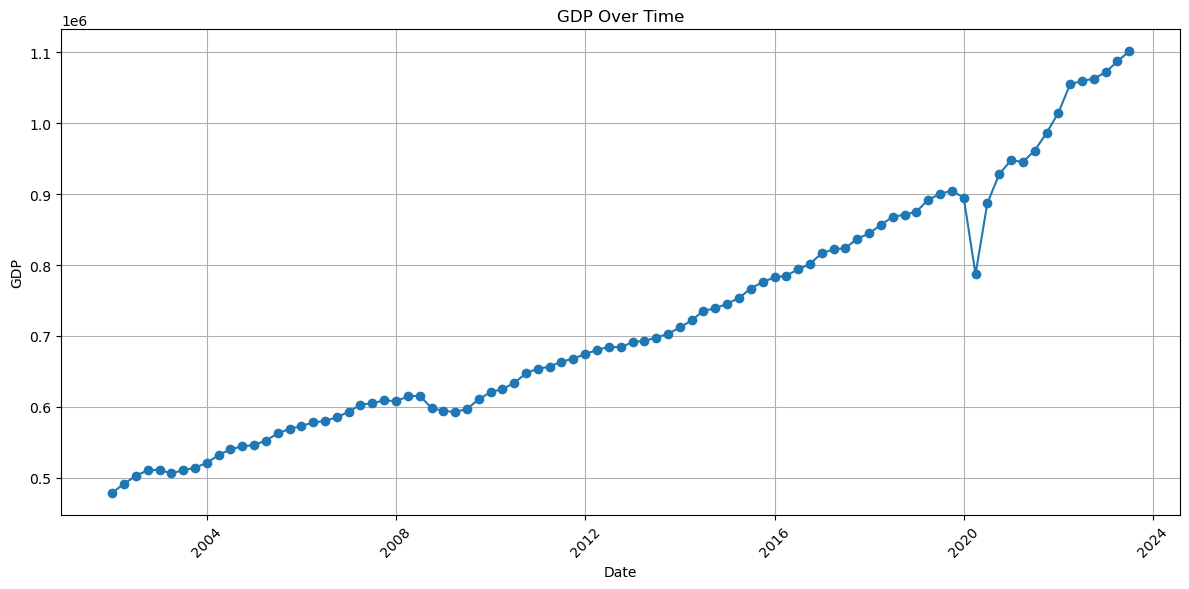

In [309]:
import matplotlib.pyplot as plt

# Plot GDP over time
plt.figure(figsize=(12, 6))
plt.plot(df_gdp.index, df_gdp['GDP'], marker='o', linestyle='-')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [310]:
## Remove covid sharp drop in GDP since it is an outlier

covid_start_date = '2020-03-01'
covid_end_date = '2021-03-01'

# Remove data between the start and end dates
df_gdp = df_gdp.loc[~((df_gdp.index >= covid_start_date) & (df_gdp.index < covid_end_date))]

## Calculate the average gain in GDP per year

average_gain = df_gdp['GDP'].diff().mean() 

## Impute the missing values with the average gain in GDP per year

df_gdp['GDP'] = df_gdp['GDP'].fillna(method='ffill') + average_gain


In [312]:
# Step 4: Impute missing values
df_gdp.loc[(df_gdp.index >= covid_start_date) & (df_gdp.index < covid_end_date), 'GDP'] = average_gain

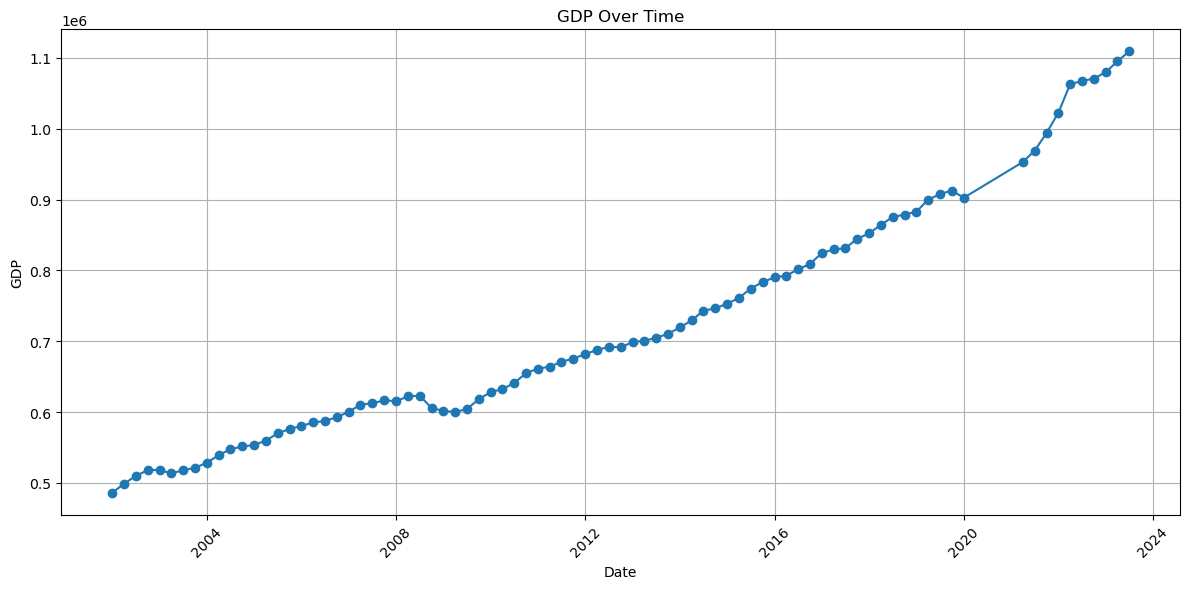

In [313]:
## Visualize the GDP data after imputation
# Plot GDP over time
plt.figure(figsize=(12, 6))
plt.plot(df_gdp.index, df_gdp['GDP'], marker='o', linestyle='-')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [314]:
## Check missing values 
df_gdp.isnull().sum()
print(df_gdp.info())    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2002-01-01 to 2023-07-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GDP      83 non-null     float64
 1   Quarter  83 non-null     object 
 2   Month    83 non-null     object 
dtypes: float64(1), object(2)
memory usage: 2.6+ KB
None


In [315]:
## Interpolate dataframe to hourly time frame 

## Drop the 'Quarter' and 'Month' columns

df_gdp = df_gdp.drop(columns=['Quarter', 'Month'])

## Resample the DataFrame to hourly frequency and interpolate missing values

df_gdp = df_gdp.resample('H').interpolate(method ='linear')




In [316]:
## View the first few rows of the DataFrame
df_gdp.head(50)



,GDP
Date,
2002-01-01 00:00:00,486347.719512
2002-01-01 01:00:00,486353.444049
2002-01-01 02:00:00,486359.168586
2002-01-01 03:00:00,486364.893123
2002-01-01 04:00:00,486370.617660
2002-01-01 05:00:00,486376.342197
2002-01-01 06:00:00,486382.066734
2002-01-01 07:00:00,486387.791271
2002-01-01 08:00:00,486393.515808


In [318]:
## Check missing values 
df_gdp.isnull().sum()
print(df_gdp.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188425 entries, 2002-01-01 00:00:00 to 2023-07-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   GDP     188425 non-null  float64
dtypes: float64(1)
memory usage: 2.9 MB
None


In [ ]:
## Convert the GDP column to float
df_gdp['GDP'] = df_gdp['GDP'].str.replace(',', '').astype(float)



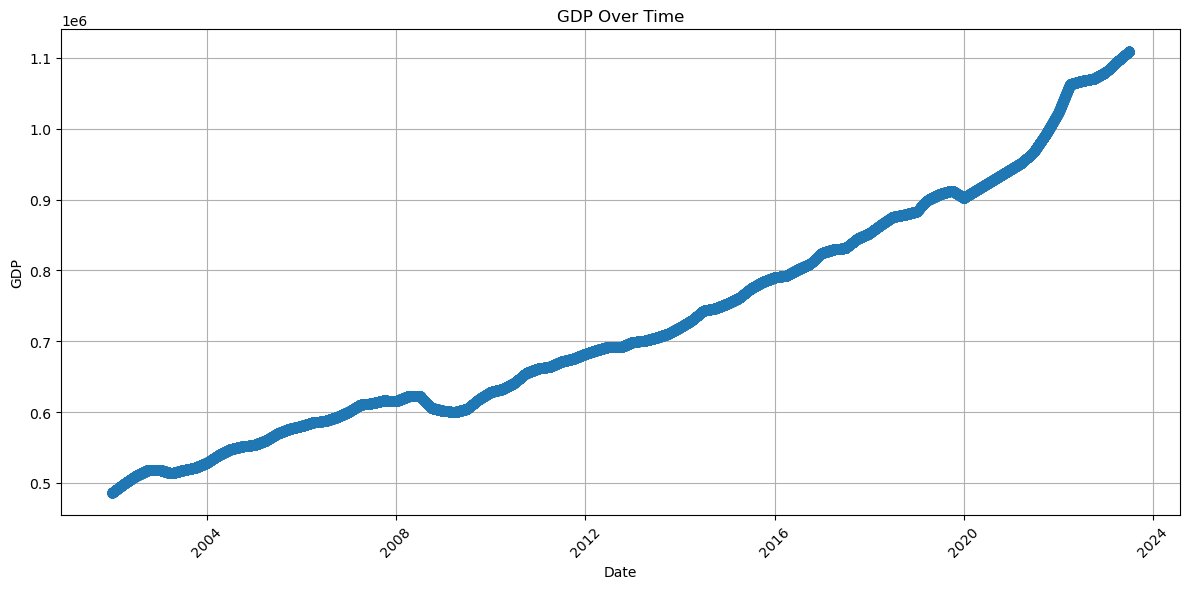

In [317]:
## Plot the GDP data after resampling and interpolation

# Plot GDP over time
plt.figure(figsize=(12, 6))
plt.plot(df_gdp.index, df_gdp['GDP'], marker='o', linestyle='-')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [321]:
# Save the cleaned GDP data to a CSV file in the cleaned data directory
cleaned_gdp_file_path = os.path.join(cleaned_data_dir, 'cleaned_gdp_data.csv')
df_gdp.to_csv(cleaned_gdp_file_path)

print(f"Cleaned GDP data saved to: {cleaned_gdp_file_path}")

Cleaned GDP data saved to: cleaned_data/cleaned_gdp_data.csv


### Population Data 

In [333]:
df_pop = pd.read_csv('ontario_population.csv')

In [334]:
## Check the first few rows of the DataFrame
df_pop.head(10)

,Year,Population,Year on Year Change,Change in Percent
0,2000,"11,216",-,-
1,2001,"11,283",67,0.6%
2,2002,"11,278",-5,-0.04%
3,2003,"11,229",-49,-0.43%
4,2004,"11,178",-51,-0.45%
5,2005,"11,196",18,0.16%
6,2006,"11,199",3,0.03%
7,2007,"11,236",37,0.33%
8,2008,"11,152",-84,-0.75%
9,2009,"11,123",-29,-0.26%


In [335]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 23 non-null     int64 
 1   Population           23 non-null     object
 2   Year on Year Change  23 non-null     object
 3   Change in Percent    23 non-null     object
dtypes: int64(1), object(3)
memory usage: 864.0+ bytes


In [336]:
## Change the Population column to integer

df_pop['Population'] = df_pop['Population'].str.replace(',', '').astype(int)


In [337]:
## Make year column a datetime object
df_pop['Year'] = pd.to_datetime(df_pop['Year'], format='%Y')
df_pop.set_index('Year', inplace=True)
df_pop.head(50)


,Population,Year on Year Change,Change in Percent
Year,,,
2000-01-01,11216,-,-
2001-01-01,11283,67,0.6%
2002-01-01,11278,-5,-0.04%
2003-01-01,11229,-49,-0.43%
2004-01-01,11178,-51,-0.45%
2005-01-01,11196,18,0.16%
2006-01-01,11199,3,0.03%
2007-01-01,11236,37,0.33%
2008-01-01,11152,-84,-0.75%


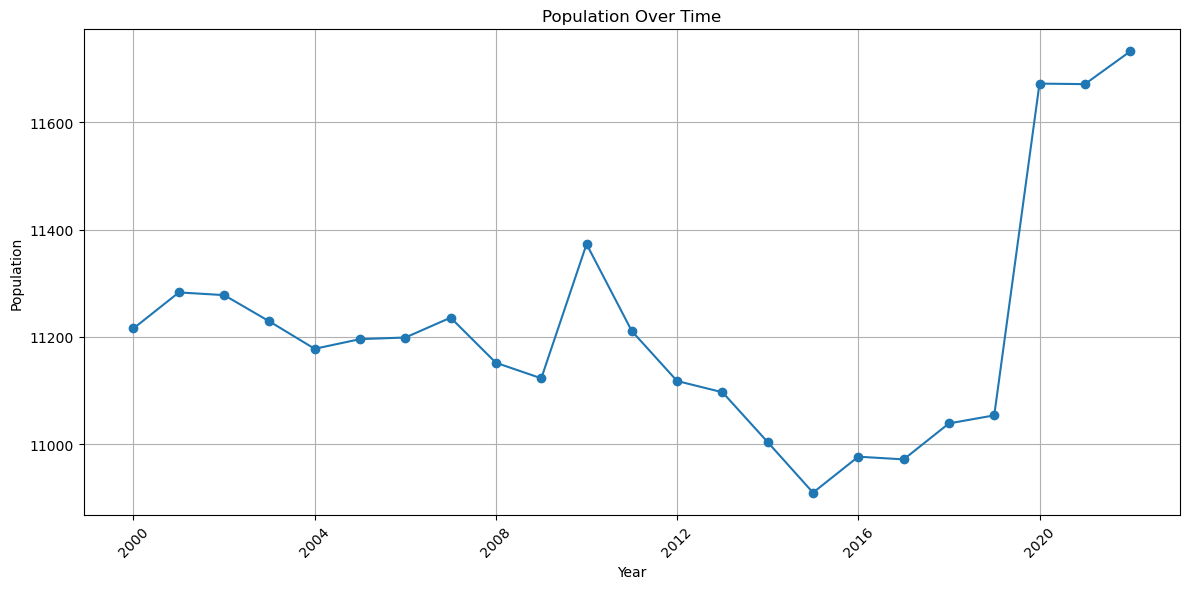

In [338]:
## Plot the population data

# Plot population over time
plt.figure(figsize=(12, 6))
plt.plot(df_pop.index, df_pop['Population'], marker='o', linestyle='-')
plt.title('Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [340]:
## Interpolate the population data to hourly time frame

## Resample the DataFrame to hourly frequency and interpolate missing values

## Drop year on year change and change in percent columns 

df_pop = df_pop.drop(columns=['Year on Year Change', 'Change in Percent'])

df_pop = df_pop.resample('H').interpolate(method ='linear')

## View the first few rows of the DataFrame
df_pop.head(50)


,Population
Year,
2000-01-01 00:00:00,11216.000000
2000-01-01 01:00:00,11216.007628
2000-01-01 02:00:00,11216.015255
2000-01-01 03:00:00,11216.022883
2000-01-01 04:00:00,11216.030510
2000-01-01 05:00:00,11216.038138
2000-01-01 06:00:00,11216.045765
2000-01-01 07:00:00,11216.053393
2000-01-01 08:00:00,11216.061020


In [341]:
## Save the cleaned population data to a CSV file in the cleaned data directory

cleaned_population_file_path = os.path.join(cleaned_data_dir, 'cleaned_population_data.csv')
df_pop.to_csv(cleaned_population_file_path)

print(f"Cleaned population data saved to: {cleaned_population_file_path}")

Cleaned population data saved to: cleaned_data/cleaned_population_data.csv
